# Human RNA editing landscape of REDIportal (GPU-based)

### Part IV Clustering all 21-mers feature of Alu editing sites in REDIportal (Human, hg38)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Hardware

- Sytem: Ubuntu 18.04.5 LTS
- CPU: Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz (12 cores)
- Disk: SAMSUNG MZ7LH960HAJR-00005 (SSD)
- RAM: 64G(32Gx2) DDR4 2666MHz
- GPU: RTX2080Ti (Driver Version: 495.29.05, CUDA Version: 11.5)

## Container Environment

**RAPIDS 21.12** (see https://rapids.ai/start.html)
- Ubuntu 20.04
- All packages
- Python 3.8
- CUDA 11.5

## 0. Configure the environment

In [1]:
import numpy as np
import pandas as pd
from cuml import UMAP
from cuml import HDBSCAN
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tracemalloc
import scipy.stats
import os

tracemalloc.start()

import time
time0 = time.time()

In [2]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCG"])

def onehot_enc(seq):
    seq = [[i] for i in seq]
    return enc.transform(seq).toarray().reshape(-1)

In [3]:
def get_table_and_onehot(fn, REP_level=None):
    onehot_input = []
    
    df = pd.read_csv(fn, index_col=0, header=0)
    if REP_level is not None:
        df = df.loc[df["type"]==REP_level]
    print(df.shape)
    
    for seq in df["motif_F10"]:
            onehot_input.append(onehot_enc(seq))
    onehot_input = np.array(onehot_input)
    print(onehot_input.shape)
    
    return df, onehot_input

In [4]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom'):
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    time0 = time.time()
    
    model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method)
    yhat = model.fit(X)
    labels = yhat.labels_
    
    time1 = time.time() - time0
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN time: {} sec".format(time1))
    print("Cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    return df

In [5]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0, draw_contour=False):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=12) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    if draw_contour == True:
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([df["X"], df["Y"]])
        kernel = scipy.stats.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)

In [6]:
def extract_fasta(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10"):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/fasta_dna".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/fasta_dna".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
        with open("./{}/fasta_dna/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column]))  
                N += 1
            # print("Cluster #{}: {}".format(g, N))

## 1. Load data from deduplicated table (Alu repeats)

**It takes one hour to load the file. If you already have onehot encoded file, load it directly.**

In [7]:
# onehot_input = np.load('./onehot.alu.npy')

In [8]:
import warnings
# long time...
warnings.filterwarnings('ignore')

time0 = time.time()
df, onehot_input = get_table_and_onehot("./REDIportal_hg38.F10.collapse.level1.ATCG.csv", REP_level="ALU")
print("Data loaded: {} sec".format(time.time()-time0))
current, peak = tracemalloc.get_traced_memory()
current = current/1024./1024.
peak = peak/1024./1024.
print("RAM:")
print("Current: {} MB".format(current))
print("Peak: {} MB".format(peak))
print(df.head())
print("===================================")

(3845893, 10)
(3845893, 84)
Data loaded: 2281.959748506546 sec
RAM:
Current: 1099.8189401626587 MB
Peak: 2377.1479110717773 MB
            key Region  Position Strand Ref Ed type      repeat  \
0  chr1@87158@-   chr1     87158      -   T  C  ALU  SINE/AluJo   
1  chr1@87168@-   chr1     87168      -   T  C  ALU  SINE/AluJo   
2  chr1@87171@-   chr1     87171      -   T  C  ALU  SINE/AluJo   
3  chr1@87189@-   chr1     87189      -   T  C  ALU  SINE/AluJo   
4  chr1@87218@-   chr1     87218      -   T  C  ALU  SINE/AluJo   

               motif_F10  collapse  
0  ACTGCACTCCAGCCTGGGTGA     False  
1  TGGTCACACCACTGCACTCCA     False  
2  CCATGGTCACACCACTGCACT     False  
3  GGTTGAGGCCACAGTGAGCCA     False  
4  CTGAGGTGGTAGGATCACTTG     False  


In [9]:
with open('onehot.alu.npy', 'wb') as f:
    np.save(f, onehot_input)

## 2. UMAP with cuML

In [10]:
# if have computed data

In [11]:
#df = pd.read_csv("./REDIportal_hg38.F10.collapse.level1.ALU.UMAP.csv", index_col=0, header=0)
#print(df.shape)

In [12]:
time0 = time.time()
umap_2d = UMAP(init="random", random_state=42, min_dist=0.01, n_neighbors=20)
proj_2d = umap_2d.fit_transform(onehot_input)
print("UMAP finished: {} sec".format(time.time()-time0))

time0 = time.time()
df["X"] = proj_2d[:, 0]
df["Y"] = proj_2d[:, 1]
print("Corrdinates loaded into dataframe: {} sec".format(time.time()-time0))

df.to_csv("./REDIportal_hg38.F10.collapse.level1.ALU.UMAP.csv")

UMAP finished: 438.3764615058899 sec
Corrdinates loaded into dataframe: 0.009309530258178711 sec


In [13]:
print(df.head())

            key Region  Position Strand Ref Ed type      repeat  \
0  chr1@87158@-   chr1     87158      -   T  C  ALU  SINE/AluJo   
1  chr1@87168@-   chr1     87168      -   T  C  ALU  SINE/AluJo   
2  chr1@87171@-   chr1     87171      -   T  C  ALU  SINE/AluJo   
3  chr1@87189@-   chr1     87189      -   T  C  ALU  SINE/AluJo   
4  chr1@87218@-   chr1     87218      -   T  C  ALU  SINE/AluJo   

               motif_F10  collapse          X         Y  
0  ACTGCACTCCAGCCTGGGTGA     False  11.530243  4.172266  
1  TGGTCACACCACTGCACTCCA     False -13.559540 -1.418940  
2  CCATGGTCACACCACTGCACT     False   0.444818 -4.752745  
3  GGTTGAGGCCACAGTGAGCCA     False   5.683571 -3.345579  
4  CTGAGGTGGTAGGATCACTTG     False -13.059052 -1.035238  


## 3. Draw 2D histograms for k-mers

In [23]:
def draw_2D_hist(df, fn):
    xlim = [-16, 16]
    ylim = [-16, 16]

    vmax = 0.05
    norm = None
    cmin = None
    density = True

    fig, ax = plt.subplots(figsize=[6,6])
    ax.set_aspect('equal', 'box')
    ax.hist2d(df["X"], df["Y"], range=[xlim, ylim], vmax=vmax, bins=[600, 600], cmin=cmin, density=density, norm=norm)
    ax.set_title("A-to-I editing (ALU)")
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(fn, dpi=300)

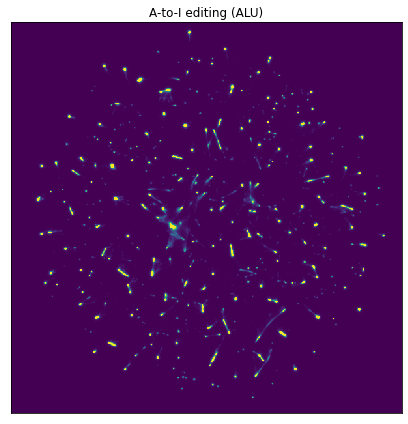

In [24]:
draw_2D_hist(df, "REDIportal_hg38.UMAP.ALU.kmers.png")

## 4. Retrive number of sites

In [16]:
# load table if already have
# df_all = pd.read_csv("./REDIportal_hg38.F10.ALU.retrived.UMAP.csv", index_col=0, header=0)

In [17]:
# We did not set a index for sequences, so it is better to get corrdinates from the 21-mers table and store it in a dict
time0 = time.time()
data_XY = {}
def get_xy(row):
    data_XY[row["motif_F10"]] = (row["X"], row["Y"])
df.apply(get_xy, axis=1)
print("Corrdinates loaded into dict: {} sec".format(time.time()-time0))

Corrdinates loaded into dict: 101.66678977012634 sec


In [18]:
indexes = []
Xs = []
Ys = []
def mark_xy(row):
    global indexes, Xs, Ys
    XY = data_XY.get(row["motif_F10"])
    if XY is not None:
        X, Y = XY
        Xs.append(X)
        Ys.append(Y)
        indexes.append(row.name)
time0 = time.time()
df_all = pd.read_csv("./REDIportal_hg38.F10.csv", index_col=None, header=0)
df_all = df_all[["key", "Region", "Position", "Strand", "Ref", "Ed", "type", "repeat", "motif_F10"]]
df_all.apply(mark_xy, axis=1)
df_all.loc[indexes, "X"] = Xs
df_all.loc[indexes, "Y"] = Ys
df_all = df_all.loc[indexes]
print("Original table marked: {} sec".format(time.time()-time0))
print(df_all.shape)
df_all.to_csv("./REDIportal_hg38.F10.ALU.retrived.UMAP.csv")

Original table marked: 334.72259044647217 sec
(14186841, 11)


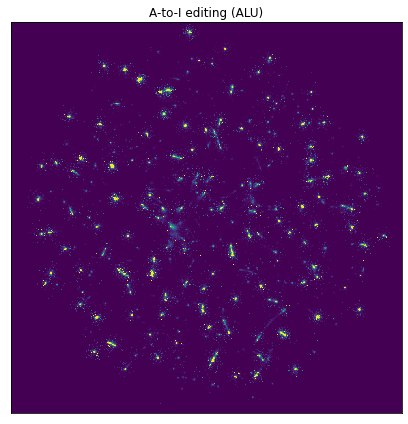

In [25]:
draw_2D_hist(df_all, "REDIportal_hg38.UMAP.ALU.real_count.png")

**HDBSCAN require huge amount of memory. Stop here.**

In [20]:
# df_all = cluster_HDBSCAN(df_all,  min_cluster_size=100, min_samples=5, cluster_selection_epsilon=0.)